This document gives an introduction to computing and visualizing various <a href = "https://arxiv.org/abs/1309.3445">Abelian networks</a> in Julia. 

For a tutorial on installing Julia and setting up Jupyter notebooks see <a href = "https://datatofish.com/add-julia-to-jupyter/">here</a>. For a general introduction to Julia from the viewpoint of Linear Algebra, <a href = "https://web.stanford.edu/class/engr108/julia.html">check out this page</a>. 

See <a href = "https://math7710.wordpress.com/blog/">here</a> for model definitions and more information. 

In [100]:
using Plots # for visualization to install type in ] add Plots 

# Abelian Sandpile

In [101]:
#######################
## Description 
##		computes the stabilization of the 2-dimensional
##		sandpile on a square
## Inputs
## 		S: an array of integers specifying the initial condition  
## Output
##      returns odometer, T, sandpile S is stabilized in place 

function stabilize!(S)
    #initialize the all 0 odometer
    T = fill(0, size(S))
    
    #iterate over all sites and try to topple 
    #until it is not possible anymore 
    isTopple = true; 
    while(isTopple)
        isTopple = false
        for y in 1:size(S,2)
            for x in 1:size(S,1)
                isTopple = isTopple | topple!(S,T,x,y)
            end
        end
    end
    
    return T;
end

## fire a single site in S once 
## i.e. increment odometer  
## remove chips from S[x,y]
## and give chips to neighbors 
## (x+1,y), (x-1,y), (x,y+1), (x,y-1)
function topple!(S,T,x,y)
    #number of times fire site (x,y)
    #we take max in case there is a hole at (x,y)
    z = max(floor(S[x,y]/4), 0) 
    #increment the odometer
    T[x,y]+=z
    S[x,y]-=4*z; 
    
    #give sand to each neighbor
    if(x > 1)
        S[x-1,y]+=z
    end
    if(x < size(S,1))
        S[x+1,y]+=z
    end
    if(y > 1)
        S[x,y-1]+=z
    end
    if(y < size(S,2))
        S[x,y+1]+=z
    end
    
    #if we have toppled return true
    #else return false
    if(z > 0) 
        return true; 
    else
        return false
    end
end


topple! (generic function with 2 methods)

##### Abelian sandpile examples

We compute several examples of Abelian sandpiles using the above function.

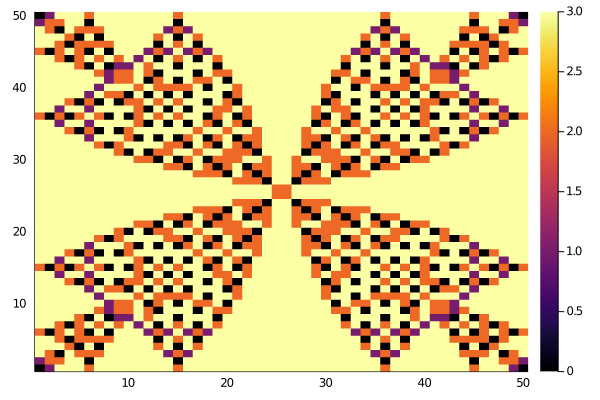

In [102]:
N = 50
S = fill(4,N,N)
T = stabilize!(S)
heatmap(S)

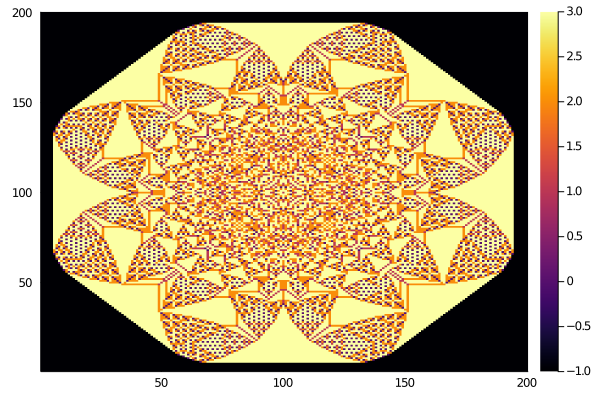

In [103]:
N = 200
S = fill(1,N,N)
S[div(N,2),div(N,2)]+=N^2
T = stabilize!(S); #will take a couple of seconds
S[T.==0].=-1;
heatmap(S)

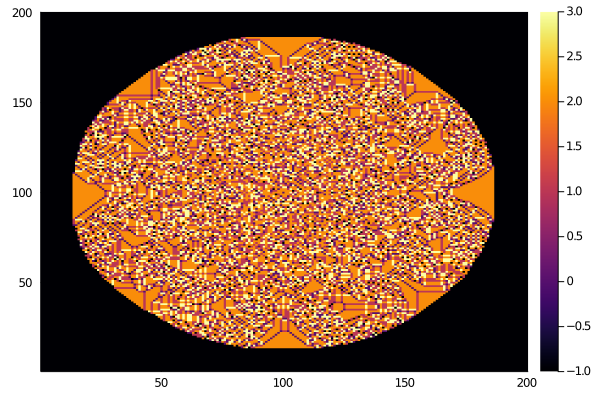

In [104]:
N = 200
S = rand(0:1,N,N)
init_condition = copy(S)
S[div(N,2),div(N,2)]+=N^2
T = stabilize!(S) #will take a couple of seconds
S = S .- init_condition
S[T.==0].=-1;
heatmap(S)

##### Efficient computation of symmetric Abelian sandpiles in arbitrary dimensions

If you have access to a GPU and want to compute large symmetric (e.g. single-source, constant, ...) sandpiles in $\mathbf{Z}^d$ <a href = "https://github.com/nitromannitol/arbitrarydim_sandpiles"> see code here</a>. This code uses symmetry of the initial condition to reduce to computing the sandpile on the simplex, $\mathcal{S}_M = \{ (x_1, \ldots, x_d) \in \mathbf{Z}^d | M \leq x_1 \leq \cdots \leq x_d \leq 1 \}$. In high dimensions, computing sandpiles on the simplex improves space complexity by a factor of $d^d$. This reduction in size also leads to a faster algorithm when using parallelization. 


For example, an NVDIA RTX 2080 TI can compute the sandpile on $\mathbf{Z}^4$ started with $2^{30}$ chips at the origin in about a day:

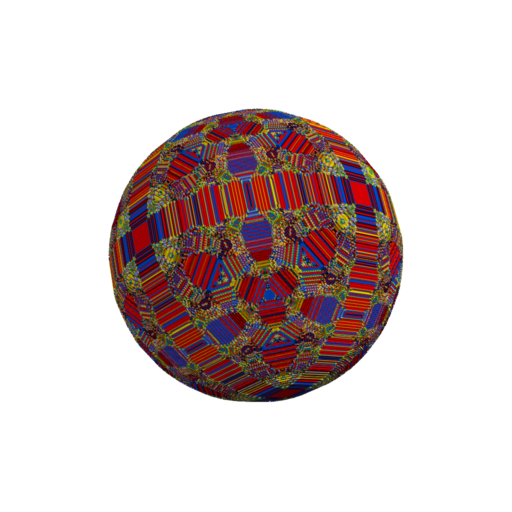


## Exploding sandpiles 

We visualize exploding sandpiles via the parallel toppling procedure. 
First we modify the above code to perform parallel updates, then look at two examples 
of parallel toppling sandpiles. 


In [105]:
#######################
## Description 
##		computes num_iter parallel topple updates of a sandpile on a square
## Inputs
## 		S: an array of integers specifying the sandpile  
## 		T: an array of integers specifying current odometer  
## 		num_iters: an integer specifying how many parallel update steps to take  
## Output
##      sandpile S is updated in place 

function parallel_topple!(S, T, num_iters)
    
    for i in 1:num_iters 
        S_prev = copy(S)
        for y in 1:size(S,2)
            for x in 1:size(S,1)
                one_topple!(S,S_prev,T,x,y)
            end
        end
    end
end
    

## fire a single site in S once 
## via the parallel update procedure
function one_topple!(S,S_prev, T,x,y)
    ## now topple according to how many 
    ## grains it had at the PREVIOUS
    ## time step
    z = max(floor(S_prev[x,y]/4), 0) 
    
    #number of times fire site (x,y)
    #we take max in case there is a hole at (x,y)
    #increment the odometer
    T[x,y]+=z
    S[x,y]-=4*z; 
    
    #give sand to each neighbor
    if(x > 1)
        S[x-1,y]+=z
    end
    if(x < size(S,1))
        S[x+1,y]+=z
    end
    if(y > 1)
        S[x,y-1]+=z
    end
    if(y < size(S,2))
        S[x,y+1]+=z
    end
end



one_topple! (generic function with 1 method)

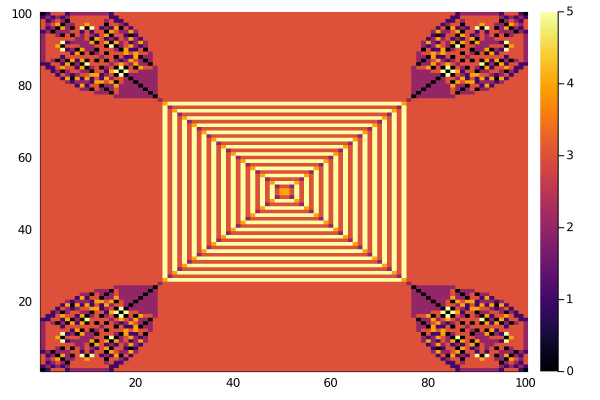

In [106]:
## start with all 4s everywhere in a square of side length 200
## and parallel topple for (25)^2 time steps
N = 100
S = fill(4,N,N)
T = fill(0,N,N)
parallel_topple!(S, T, (25)^2)
heatmap(S)

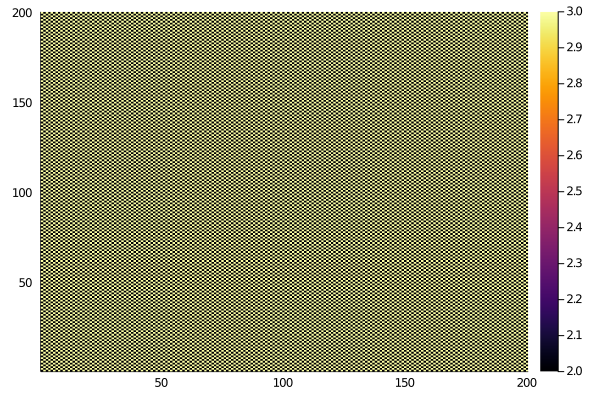

In [107]:
## start with a checkerboard 2,3 in a square
## and parallel topple for (25)^2 time steps
N = 200
S = [2+(x+y)%2 for x in 1:N, y in 1:N]
T = fill(0,N,N)
#initial checkerboard 
heatmap(S)

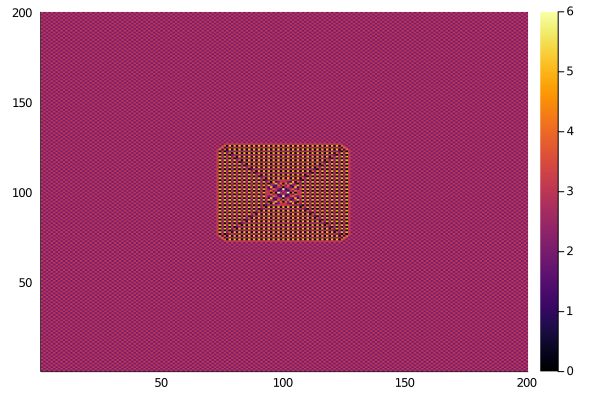

In [108]:
#place M grains at the origin and parallel topple for M steps
## start with a checkerboard 2,3 in a square
## and parallel topple for (M) time steps
M = 50
S[div(N,2),div(N,2)]=M
parallel_topple!(S, T, M)
heatmap(S)

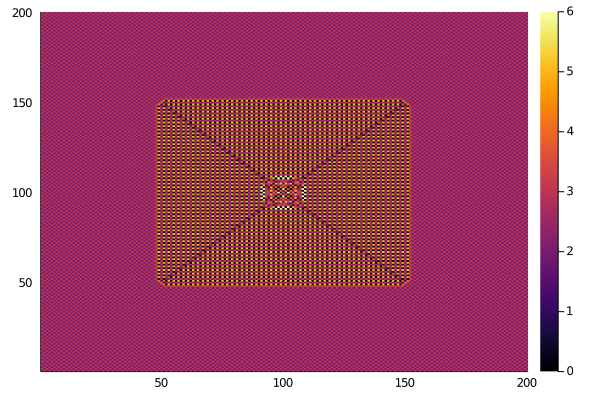

In [109]:
#place another M grains at the origin and parallel topple for M steps
S[div(N,2),div(N,2)]+=M
parallel_topple!(S, T, M)
heatmap(S)

### Torus sandpiles

We set up the sandpile Markov chain on the discrete torus $(\mathbf{Z} \backslash M \mathbf{Z})^2$ and compute when an iid Bernoulli sandpile does not stabilize on the torus

In [110]:
#######################
## Description 
##		computes the stabilization of the 2-dimensional
##		sandpile on a TORUS if possible
## Inputs
## 		S: an array of integers specifying the initial condition  
## Output
##      returns true/false if stabilization was successful
##      also returns the odometer 

function stabilize_torus!(S)
    #initialize the all 0 odometer
    T = fill(0, size(S))
    
    #iterate over all sites and try to topple 
    #until it is not possible anymore 
    isTopple = true; 
    while(isTopple && !(all(T.>0)))
        isTopple = false
        for y in 1:size(S,2)
            for x in 1:size(S,1)
                isTopple = isTopple | topple_torus!(S,T,x,y)
            end
        end
    end
    
    return !all(T.>0), T
    
end

## fire a single site in S once 
## with torus boundary conditions
function topple_torus!(S,T,x,y)
    #number of times fire site (x,y)
    #we take max in case there is a hole at (x,y)
    z = max(floor(S[x,y]/4), 0) 
    #increment the odometer
    T[x,y]+=z
    S[x,y]-=4*z; 
    
    #give sand to each neighbor
    if(x > 1)
        S[x-1,y]+=z
    else
        S[size(S,1),y]+=z
    end
    if(x < size(S,1))
        S[x+1,y]+=z
    else
        S[1,y]+=z
    end
    if(y > 1)
        S[x,y-1]+=z
    else
        S[x,size(S,2)]+=z
    end
    if(y < size(S,2))
        S[x,y+1]+=z
    else
        S[x,1]+=z
    end
    
    #if we have toppled return true
    #else return false
    if(z > 0) 
        return true; 
    else
        return false
    end
end


topple_torus! (generic function with 1 method)

In [111]:
#the sandpile with 3 grains of sand + one extra chip is not stabilizable on the torus!
N = 10
S = fill(3,N,N)
S[1,1]+=1 
isStable, T = stabilize_torus!(S)


(false, [1 1 … 1 1; 1 1 … 1 1; … ; 1 1 … 1 1; 1 1 … 1 1])

In [131]:
## compute empirical distribution of p when a 4*Bernoulli(p) sandpile fails to stabilize on N x N torus

num_p = 100
p_s = range(0,1,length=num_p)
N = 50 
num_trials = 100


# vector to store first time you fail to stabilize
# over the 
fail_p  = fill(0.0, num_trials)

@time for i in 1:num_trials #will take a few seconds
    max_p = 0
    for p in p_s
        S = 4*(rand(N,N).<p)
        isStable, T = stabilize_torus!(S)
        if(!isStable)
            break;
        end
        max_p = p
    end
    fail_p[i] = max_p
end




  5.717218 seconds (395.13 k allocations: 785.015 MiB, 0.79% gc time)


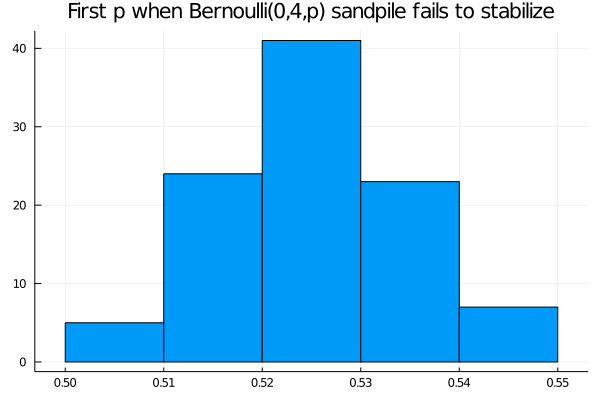

In [132]:
histogram(fail_p, label=false, title = "First p when Bernoulli(0,4,p) sandpile fails to stabilize")

In [114]:
## how does this compare to the threshold when this sandpile begins to lose a macroscopic amount
## of sand to the sink?

dens_vec  = fill(0.0, num_p)
mean_vec = fill(0.0,num_p)
for i in 1:num_p
    p = p_s[i]
    S = 4*(rand(N,N).<p)
    mean_vec[i] = sum(S)/length(S)
    stabilize!(S) #uses function defined above
    dens_vec[i] = sum(S)/length(S)
end




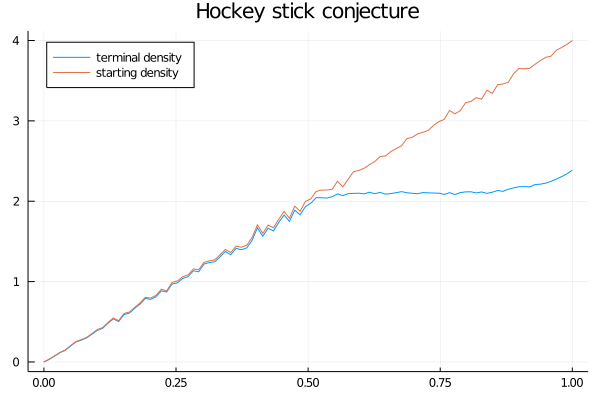

In [115]:
plot(p_s,dens_vec,label="terminal density", legend = :topleft, title = "Hockey stick conjecture")
plot!(p_s, mean_vec, label = "starting density")

# Divisible sandpile

We compute an approximation of the single-source divisible sandpile on $\mathbf{Z}^2$. This implementation is essentially <a href = "https://en.wikipedia.org/wiki/Jacobi_method"> Jacobi iteration</a> for computing 
the solution to a linear equation. 

In [116]:
#######################
## Description 
##		computes an APPROXIMATION of 
##      the stabilization of the 2-dimensional
##		DIVISIBLE sandpile on a square
## Inputs
## 		S: an array of real numbers specifying the initial condition  
## Output
##      returns odometer, T, sandpile S is "almost" stabilized in place with error eps

function stabilize_div!(S)
    #initialize the all 0 odometer
    T = fill(0.0, size(S))
    
    eps = 0.01;
    #iterate over all sites and topple until every site
    #has fewer than 3 + eps grains of sand
    while(!all(S.<3+eps))
        for y in 1:size(S,2)
            for x in 1:size(S,1)
                topple_div!(S,T,x,y)
            end
        end
    end
    
    return T;
end

## excess mass, (S[x,y]-3)^+
## is divided equally and given to each neighbor
function topple_div!(S,T,x,y)
    #number of times fire site (x,y)
    z = max(S[x,y]-3,0)
    
    
    #increment the odometer
    T[x,y]+=z
    S[x,y]-=z; 
    
    #give excess mas to each neighbor
    if(x > 1)
        S[x-1,y]+=z/4
    end
    if(x < size(S,1))
        S[x+1,y]+=z/4
    end
    if(y > 1)
        S[x,y-1]+=z/4
    end
    if(y < size(S,2))
        S[x,y+1]+=z/4
    end
    
end


topple_div! (generic function with 1 method)

In [117]:
N = 50; 
S = fill(0.0,N,N)
S[div(N,2),div(N,2)]+=N^2
T = stabilize_div!(S);
#notice some sites have 3+0.001 grains left

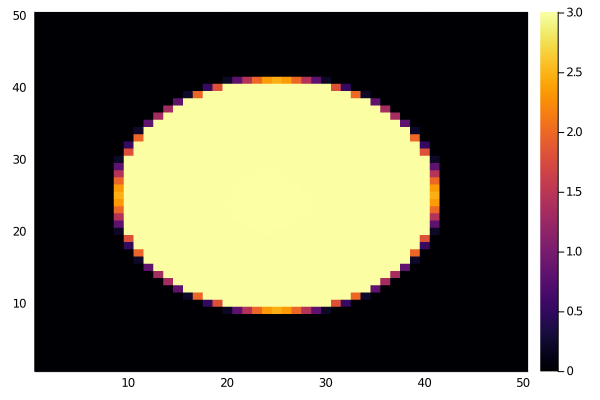

In [118]:
heatmap(S)

# Internal DLA

We compute IDLA on $\mathbf{Z}^2$ starting with a stack of particles at the origin. 

In [119]:
#######################
## Description 
##      runs one iteration of IDLA with a walker 
##      starting at site (x,y) on background cluster
## Inputs
##      cluster: an array of 0s and 1s specifying initial cluster  
##      start_x, start_y: indices into S where walker starts
## Output
##      none; dynamics are performed in place

function runIDLA_walk!(cluster, start_x, start_y)
    x = start_x; 
    y = start_y
    while(true)
        coin_flip = rand() 
        if(coin_flip < 1/4)
            x =  x + 1
        elseif(coin_flip < 1/2)
            x = x - 1
        elseif(coin_flip < 3/4)
            y = y + 1
        elseif(coin_flip < 1)
            y = y -1
        end
        
        
        #if walker exists domain stop
        if(x < 1 || y < 1 || x > size(cluster,1) || y > size(cluster,2))
            break;
        end
        
        #if walker is now at an empty site 
        #it stops
        if(cluster[x,y] == 0)
            cluster[x,y] = 1
            break;
        end 
    end
end

runIDLA_walk! (generic function with 1 method)

In [120]:
N = 100
cluster = fill(0,N,N)
num_iters = (div(N,2))^2; #run IDLA for this many iterations
for i in 1:num_iters
    runIDLA_walk!(cluster, div(N,2), div(N,2))
end

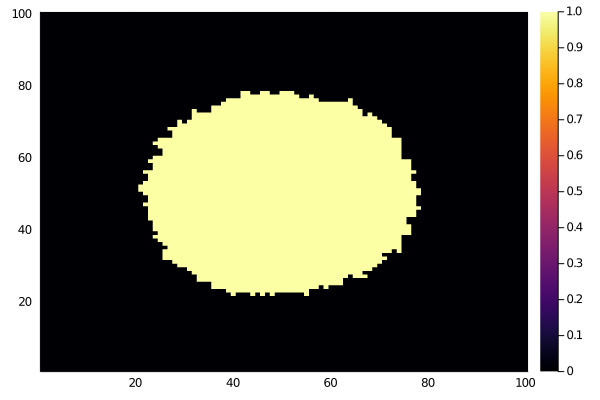

In [121]:
heatmap(cluster)

# Spinner sandpile

We compute the quenched and annealed versions of N-S, E-W spinner sandpile starting with a stack of particles at the origin. 

### Annealed   - toppling directions are resampled at every step

In [122]:
#######################
## Description 
##		computes the stabilization of the 2-dimensional
##		sandpile on a square using ANNEALED SPINNER toppling rules
## Inputs
## 		S: an array of integers specifying the initial condition  
## Output
##      returns odometer, T; sandpile S is stabilized in place 

function stabilize_spin!(S)
    #initialize the all 0 odometer
    T = fill(0, size(S))
    
    #iterate over all sites and try to topple 
    #until it is not possible anymore 
    isTopple = true; 
    while(isTopple)
        isTopple = false
        for y in 1:size(S,2)
            for x in 1:size(S,1)
                isTopple = isTopple | topple_spin!(S,T,x,y)
            end
        end
    end
    
    return T;
end

## fire a single site in S 
## i.e. increment odometer  
## remove 2 chips from S[x,y]
## and give chips to neighbors 
## (x+1,y), (x-1,y) OR (x,y+1), (x,y-1)
## depending on outcome of fair coin flip
## continue until less than 2 chips at site S
function topple_spin!(S,T,x,y)
    #number of times fire site (x,y)
    #we take max in case there is a hole at (x,y)
    z = max(floor(S[x,y]/2), 0) 
    #increment the odometer
    T[x,y]+=z
    S[x,y]-=2*z; 
    
    for i in 1:z
       if(rand() < 1/2)
            if(x > 1)
                S[x-1,y]+=1
            end
            if(x < size(S,1))
                S[x+1,y]+=1
            end
        else
            if(y > 1)
                S[x,y-1]+=1
            end
            if(y < size(S,2))
                S[x,y+1]+=1
            end
        
        end
    end
    
    #if we have toppled return true
    #else return false
    if(z > 0) 
        return true; 
    else
        return false
    end
end


topple_spin! (generic function with 1 method)

In [123]:
N = 100
S = fill(0,N,N)
S[div(N,2),div(N,2)]+=div(N,2)^2
T = stabilize_spin!(S);
S[T.==0].=-1;

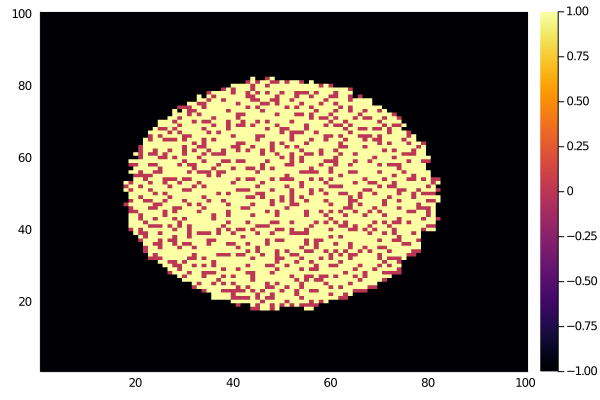

In [124]:
heatmap(S)

### Quenched - toppling directions are fixed at the beginning

In [125]:
#######################
## Description 
##		computes the stabilization of the 2-dimensional
##		sandpile on a square using QUENCHED SPINNER toppling rules
## Inputs
## 		S: an array of integers specifying the initial condition  
## Output
##      returns odometer, T; sandpile S is stabilized in place 

function stabilize_spin_quenched!(S)
    #initialize the all 0 odometer
    T = fill(0, size(S))
    
    #initialize the toppling directions 
    dir_mat = rand(size(S,1), size(S,2))
    
    
    #iterate over all sites and try to topple 
    #until it is not possible anymore 
    isTopple = true; 
    while(isTopple)
        isTopple = false
        for y in 1:size(S,2)
            for x in 1:size(S,1)
                isTopple = isTopple | topple_spin_quenched!(S,T,x,y, dir_mat)
            end
        end
    end
    
    return T;
end

## fire a single site in S 
## i.e. increment odometer  
## remove 2 chips from S[x,y]
## and give chips to neighbors 
## (x+1,y), (x-1,y) OR (x,y+1), (x,y-1)
## depending on quenched toppling direction dir_mat
## continue until less than 2 chips at site S
function topple_spin_quenched!(S,T,x,y,dir_mat)
    #number of times fire site (x,y)
    #we take max in case there is a hole at (x,y)
    z = max(floor(S[x,y]/2), 0) 
    #increment the odometer
    T[x,y]+=z
    S[x,y]-=2*z; 
    
    if(dir_mat[x,y] < 1/2)
        if(x > 1)
            S[x-1,y]+=z
        end
        if(x < size(S,1))
            S[x+1,y]+=z
        end
    else
        if(y > 1)
            S[x,y-1]+=z
        end
        if(y < size(S,2))
            S[x,y+1]+=z
        end
    end
    
    #if we have toppled return true
    #else return false
    if(z > 0) 
        return true; 
    else
        return false
    end
end


topple_spin_quenched! (generic function with 1 method)

In [126]:
N = 200
S = fill(0,N,N)
S[div(N,2),div(N,2)]+=div(N,2)^2
T = stabilize_spin_quenched!(S);
S[T.==0].=-1;

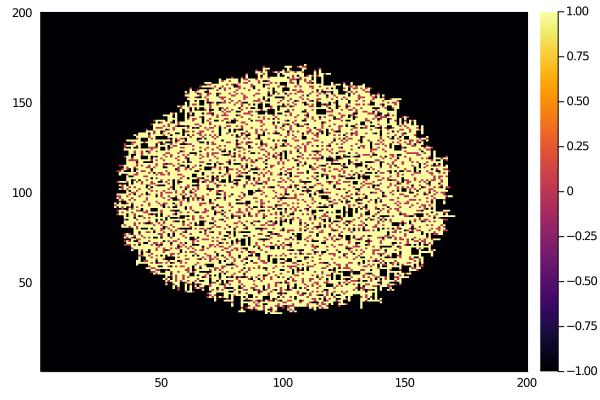

In [127]:
heatmap(S)

# Activated random walk

We compute activated random walk on $\mathbf{Z}^2$ starting with a stack of particles at the origin.


In [128]:

#######################
## Description 
##      runs ARW starting with A active particles 
##      and S sleeping particles on Z^2 until 
##      every particle is sleeping
## Inputs
##      A: an array of integers - initial active walkers  
##      S: an array of integers - initial sleeping walkers  
##      T: an array of integers - initial odometer  
##      lambda: real number sleep rate
## Output
##      none - dynamics are performed in-place

function stabilize_arw!(A,S,T, lambda)
    isTopple = true;
    while(isTopple)
        isTopple = false
        for x in 1:size(A,1)
            for y in 1:size(A,2)
                if(A[x,y] > 0)
                    topple_arw!(A,S,T, lambda,x,y)
                    isTopple = true; 
                end
            end
        end
    end
end

#one active walker at site x,y
function topple_arw!(A,S,T, lambda,x,y)
    ## wake up every particle at the site
    A[x,y]=A[x,y]+S[x,y]
    S[x,y]=0
    
    #each particle moves or falls asleep
    for i in 1:length(A[x,y])
        A[x,y]-=1
        T[x,y]+=1
        if(rand() < lambda/(1+lambda))
            #go to sleep 
            S[x,y]+=1
        else
            #flip a coin to decide where the walker moves
            coin_flip = rand()
            if(coin_flip < 1/4)
                if(x < size(A,1))
                    A[x+1,y]+=1
                end
            elseif(coin_flip < 1/2)
                if(x > 1)
                    A[x-1,y]+=1
                end
            elseif(coin_flip < 3/4)
                if(y < size(A,2))
                    A[x,y+1]+=1
                end
            else
                if(y > 1)
                    A[x,y-1]+=1
                end
            end
        end
    end

end


topple_arw! (generic function with 1 method)

In [129]:
N=100
lambda = 1; ## sleeping rate
A = fill(0,N,N) #active particles
S = fill(0,N,N) #sleeping particles
T = fill(0,N,N) #odometer
A[div(N,2),div(N,2)]+=(div(N,2))^2
@time stabilize_arw!(A,S,T,lambda);
S[T.==0].=-1;

  0.273492 seconds (57.99 k allocations: 3.144 MiB)


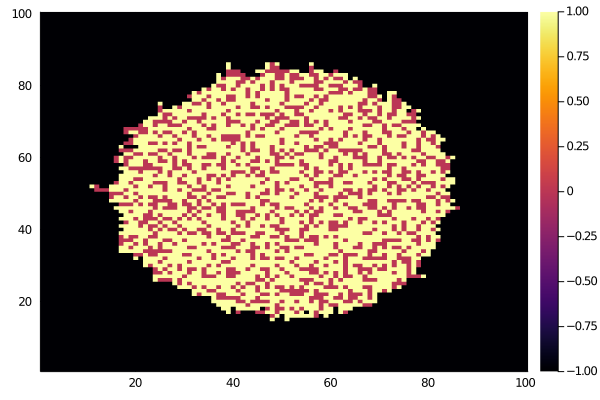

In [130]:
heatmap(S)